# Report
This is a test project for JetBrains  
I will add more information later

# Data 

In [2]:
import pandas as pd 
from vega_datasets import data

In [3]:
df = (
    data.birdstrikes()
    .rename(columns={'Cost__Total_$': 'Cost_Total'})
    .sample(4999, random_state=42)
)

df.head()

Airport__Name Aircraft__Make_Model Effect__Amount_of_damage  \
6252           ORLANDO INTL                MD-82                   Medium   
4684         NASHVILLE INTL   FOKKER F28 MK 1000                     None   
1731  AUSTIN-BERGSTROM INTL                MD-80                     None   
4742       KANSAS CITY INTL            B-727-200                     None   
4521    SALT LAKE CITY INTL            B-757-200                     None   

        Flight_Date Aircraft__Airline_Operator Origin_State  \
6252  12/15/98 0:00                US AIRWAYS*      Florida   
4684   4/28/97 0:00          AMERICAN AIRLINES    Tennessee   
1731   3/10/93 0:00          AMERICAN AIRLINES        Texas   
4742   5/19/97 0:00          AMERICAN AIRLINES     Missouri   
4521   1/14/97 0:00            DELTA AIR LINES         Utah   

     When__Phase_of_flight Wildlife__Size      Wildlife__Species  \
6252              Approach          Large         Turkey vulture   
4684          Landing Roll         Medium  Unknown bird - medium   
1731                 Climb          Small   Unknown bird - small   
4742          Landing Roll          Small          Mourning dove   
4521          Landing Roll          Small   Unknown bird - small   

     When__Time_of_day  Cost__Other  Cost__Repair  Cost_Total  \
6252               Day            0             0           0   
4684               Day            0             0           0   
1731               Day            0             0           0   
4742               Day            0             0           0   
4521               Day            0             0           0   

      Speed_IAS_in_knots  
6252               160.0  
4684               120.0  
1731               145.0  
4742               120.0  
4521               135.0

# Draco examples 

In [4]:
import draco 
from draco import dict_to_facts, schema_from_dataframe
from IPython.display import display
from draco import Draco, dict_to_facts, dict_union, answer_set_to_dict
from draco.renderer import AltairRenderer

from pprint import pprint

In [5]:
d = Draco()
renderer = AltairRenderer(concat_mode="hconcat")

## Example 1


In [6]:
scatter_plot_color = {
  'number_rows': 4999,
  'field': [
    {
      'name': 'Cost_Total',
      'type': 'number',
      '__id__': 'Cost_Total'
    },
    {
      'name': 'Speed_IAS_in_knots',
      'type': 'number',
      '__id__': 'Speed_IAS_in_knots'
    },
    {
      'name': 'Wildlife__Size',
      'type': 'string',
      '__id__': 'Wildlife__Size'
    }
  ],
  'view': [
    {
      'mark': [
        {
          'type': 'point',
          'encoding': [
            {
              'channel': 'x',
              'field': 'Cost_Total'
            },
            {
              'channel': 'y',
              'field': 'Speed_IAS_in_knots'
            },
            {
              'channel': 'color',
              'field': 'Wildlife__Size'
            }
          ]
        }
      ],
      'scale': [
        {
          'channel': 'x',
          'type': 'linear'
        },
        {
          'channel': 'y',
          'type': 'linear'
        },
        {
          'channel': 'color',
          'type': 'categorical'
        }
      ]
    }
  ]
}

In [7]:
prog = dict_to_facts(scatter_plot_color)

if not d.check_spec(prog):
    print("\n".join(prog))
    print(d.get_violations(prog))
    assert False, "Invalid spec"

In [8]:
display(renderer.render(spec=scatter_plot_color, data=df[['Cost_Total', 'Speed_IAS_in_knots', 'Wildlife__Size']]))

alt.Chart(...)

# Few shot schema approach 

In [9]:
from prompts import example_data_schema_str, example_plot_schemas_str
from dotenv import load_dotenv
from openai import OpenAI

from json import loads
import re

In [73]:
load_dotenv()

systme_prompt = f'''
You are a very good data scientist and you have been tasked with creating a visualization for the user data.
Your job is to generate plot schemas for provided data schema. 
Please keep it simple and use only the fields provided in the data schema.
Here are a few useful hints when creating a plot schema:
{example_data_schema_str}

Here are some example plot schemas:
{example_plot_schemas_str}

Now the user will provide his data schema and you have to generate a plot schema for him.
'''

In [74]:
user_schema = schema_from_dataframe(df)

In [75]:
client = OpenAI()

completion = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
        {
            'role': 'system', 
            'content': systme_prompt
        },
        {
            'role': 'user',
            'content': str(user_schema) + \
                'Now generate a plot schema for this data schema. Provide only a json schema, no explanations or comments.'
        }
    ]
)

In [76]:
json_str = re.search(r'\{.*\}', completion.choices[0].message.content, re.DOTALL).group()
plot_schema = loads(json_str)

display(renderer.render(spec=plot_schema, data=df))
pprint(plot_schema)

alt.Chart(...)

{'field': [{'__id__': 'Cost_Total', 'name': 'Cost_Total', 'type': 'number'},
           {'__id__': 'Effect__Amount_of_damage',
            'name': 'Effect__Amount_of_damage',
            'type': 'string'}],
 'number_rows': 4999,
 'view': [{'coordinates': 'cartesian',
           'mark': [{'encoding': [{'channel': 'x',
                                   'field': 'Effect__Amount_of_damage'},
                                  {'aggregate': 'mean',
                                   'channel': 'y',
                                   'field': 'Cost_Total'}],
                     'type': 'bar'}],
           'scale': [{'channel': 'x', 'type': 'ordinal'},
                     {'channel': 'y', 'type': 'linear', 'zero': 'true'}]}]}


## Conclusions 

Works fine  
Would make sence to make a loop/chat, so that we can give suggestions modify the scheme, fix errors etc.  
Also, everything that can be hardcoded should be hardcoded.  
For example size of the dataset, types of the columns etc.

# Multi agents approach

In [113]:
from typing import Literal, TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.types import Command
from numpyencoder import NumpyEncoder

import json

In [15]:
class AnalysisTask(TypedDict):
    question: str
    columns: List[str]

In [16]:
def get_schema_prompt(df: pd.DataFrame) -> str:

    schema = schema_from_dataframe(df)

    analysis_prompt = """
    Here is data schema of the dataset you are working with:
    """ + \
    f"""{json.dumps(schema, indent=2, cls=NumpyEncoder)}"""
    
    return analysis_prompt

In [17]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [18]:
def Manager(state: MessagesState) -> Command[Literal["scheme_gen"]]:

    user_prompt = get_schema_prompt(df)

    system_prompt = """
`   You are a Data Scientist. 
    Your task is to generate graphs that would give you insights into the data.
    Please select columns and formulate question that you would like to answer with the graph.
    You can select multiple columns. Some columns can be treated as colors or sizes.
    The outpust should be strictly in the following format:
    {"question": "<your question>", "columns": ["<column1>", "<column2>", ... ]}
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(AnalysisTask).invoke(messages)
    columns = response["columns"]
    global df_filtered 
    df_filtered = df[columns]

    return Command(
        update={
            "messages": [
                HumanMessage(role="user", content=f"Question: {response['question']}"),
            ]
        },
        goto="scheme_gen"
    )

In [37]:
def SchemaGenerator(state: MessagesState) -> Command[Literal["validator"]]:
    global df_filtered
    schema = schema_from_dataframe(df_filtered)
    schema = json.dumps(schema, indent=2, cls=NumpyEncoder)

    messages = state["messages"]
    question = next(m.content for m in messages if m.content.startswith("Question: "))
    remark = next((m.content for m in messages[::-1] if m.content.startswith("Remark: ")), '')

    system_prompt = f'''
    You are a very good data scientist and you have been tasked with creating a visualization for the user data.
    Your job is to generate plot schemas for provided data schema that would help answer user's question
    Pay attention to user's scheme. 
    You must use the number_rows from user's schema.
    You must use only columns provided in the user schema.
    Here is an example of the data schema:
    {example_data_schema_str}

    Here are some example plot schemas:
    {example_plot_schemas_str}

    When generating answer you must pay attention and use only correct types that are provided in the user schema or example schemas.
    You must output one json as in example schemas.
    You must use only columns provided in the user schema.
    '''

    user_prompt = f"""
    User's data schema:
    {schema}
    Question to answer: 
    {question}
    Remarks to last schema if were any:
    {remark}
    Now generate a plot schema for this data schema. Provide only a json schema, no explanations or comments.
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ] + state["messages"]

    response = llm.invoke(messages)
    json_str = re.search(r'\{.*\}', response.content, re.DOTALL).group()

    return Command(
        update={
            "messages": [
                HumanMessage(role="user", content=json_str),
            ]
        },
        goto="validator"
    )

In [38]:
def Validator(state: MessagesState) -> Command[Literal["scheme_gen", END]]:

    scheme = json.loads(state["messages"][-1].content)
    prog = dict_to_facts(scheme)
    
    if not d.check_spec(prog):
        print(d.get_violations(prog))

        return Command(
            update={
                "messages": [
                    HumanMessage(role="system", content=f"The schema is not correct. Here are the violations: {d.get_violations(prog)}"),
                ]
            },
            goto="scheme_gen"
        )

    # Display the rendered VL chart and the ASP
    chart = renderer.render(scheme, df_filtered)
    display(chart)

    return Command(
        goto=END
    )

In [39]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "manager")
builder.add_node("manager", Manager)
builder.add_node("scheme_gen", SchemaGenerator)
builder.add_node("validator", Validator)
graph = builder.compile()

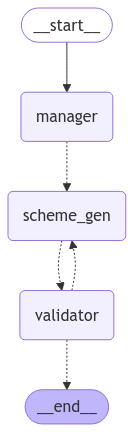

In [40]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
for s in graph.stream(
    {"messages": []}, subgraphs=True
):
    print(s)
    print("----")

((), {'manager': {'messages': [HumanMessage(content='Question: What is the distribution of damage costs associated with different wildlife species involved in aircraft incidents?', additional_kwargs={}, response_metadata={}, role='user')]}})
----
((), {'scheme_gen': {'messages': [HumanMessage(content='{\n  "number_rows": 4999,\n  "field": [\n    {\n      "name": "Wildlife__Species",\n      "type": "string",\n      "__id__": "Wildlife__Species"\n    },\n    {\n      "name": "Cost_Total",\n      "type": "number",\n      "__id__": "Cost_Total"\n    }\n  ],\n  "view": [\n    {\n      "mark": [\n        {\n          "type": "bar",\n          "encoding": [\n            {\n              "channel": "x",\n              "field": "Wildlife__Species"\n            },\n            {\n              "channel": "y",\n              "field": "Cost_Total",\n              "aggregate": "mean"\n            }\n          ]\n        }\n      ],\n      "scale": [\n        {\n          "channel": "x",\n          

alt.Chart(...)

((), {'validator': None})
----


## Conclusions 

This looks like a good approach.  
It sometimes produces errors and automatically fixes them.  
Also the graph looks much cleaner.  

PLEASE don't judge the technical realisation of the project.  
This is proof of concept.

# Draco suggest + simple prompt approach

In [129]:
from prompts import example_plot_schemas

In [130]:
example_data_facts = dict_to_facts(json.loads(example_data_schema_str))
example_data_facts_str = "\n".join(example_data_facts)

In [131]:
example_plot_facts = []
for example in example_plot_schemas:

    name = re.search(r'^#.*\n', example, re.MULTILINE).group()

    scheme = re.search(r'\{.*\}', example, re.DOTALL).group()
    scheme = scheme.replace('\'', '\"')
    scheme = loads(scheme)
    
    facts = dict_to_facts(scheme)
    example_plot_facts.append(name + '\n'.join(facts))

example_plot_facts_str = '\n'.join(example_plot_facts)

In [132]:
systme_prompt = f'''
You are a very good data scientist and you have been tasked with creating a visualization for the user data.
Your job is to generate plot schemas for provided data schema. 
Here are a few useful hints when creating a plot schema:
1. If there are many unique values, don't visualize them individually. 
Use historgram or scatterplots for that.
Also don't use type ordinal in that case for such values, only type number.
2. If there are too many unique values, don't use them as colors, there will be too many colors. 
Try to group them.
3. Using aggregate functions like mean, median, sum, etc. can be useful.
4. Generate just one good plot. Don't generate many mark plots in one scheme.
5. Keep it simple and clean. 
Here is an example of the data schema:
{example_data_facts_str}

Here are some examples of logic schemes describing different plots.
Structured like 

# <Name of the plot>
<List of logic statements>
<Descibing the plot>

{example_plot_facts_str}

Now the user will provide his data schema and you have to generate logic scheme for it.
Note that you don't need to generate all the detailed logic facts. 
We will check if facts are correct and then complete the logic scheme for you.
'''

In [133]:
client = OpenAI()

completion = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
        {
            'role': 'system', 
            'content': systme_prompt
        },
        {
            'role': 'user',
            'content': str(user_schema) + \
                'Now generate a logic scheme for this data schema. Provide only a list of logic statements, no explanations or name at the beggining. So you dont need to start it with #.'
        }
    ]
)

In [134]:
msg = completion.choices[0].message.content
print(msg)

attribute(number_rows,root,4999).
entity(field,root,0).
attribute((field,name),0,Airport__Name).
attribute((field,type),0,string).
attribute((field,unique),0,50).
attribute((field,entropy),0,3760).
attribute((field,freq),0,455).
entity(field,root,1).
attribute((field,name),1,Aircraft__Make_Model).
attribute((field,type),1,string).
attribute((field,unique),1,183).
attribute((field,entropy),1,3867).
attribute((field,freq),1,456).
entity(field,root,2).
attribute((field,name),2,Effect__Amount_of_damage).
attribute((field,type),2,string).
attribute((field,unique),2,6).
attribute((field,entropy),2,457).
attribute((field,freq),2,4461).
entity(field,root,3).
attribute((field,name),3,Flight_Date).
attribute((field,type),3,string).
attribute((field,unique),3,2743).
attribute((field,entropy),3,7762).
attribute((field,freq),3,10).
entity(field,root,4).
attribute((field,name),4,Aircraft__Airline_Operator).
attribute((field,type),4,string).
attribute((field,unique),4,46).
attribute((field,entropy),4

In [135]:
prog_gen = msg.split('\n')

if not d.check_spec(prog):
    print("\n".join(prog))
    print(d.get_violations(prog))
    assert False, "Invalid spec"

In [136]:
next(d.complete_spec(msg))

<block>:1784:1-41: error: unsafe variables in:
  attribute((field,name),0,Airport__Name):-[#inc_base].
<block>:1784:26-39: note: 'Airport__Name' is unsafe

<block>:1790:1-48: error: unsafe variables in:
  attribute((field,name),1,Aircraft__Make_Model):-[#inc_base].
<block>:1790:26-46: note: 'Aircraft__Make_Model' is unsafe

<block>:1796:1-52: error: unsafe variables in:
  attribute((field,name),2,Effect__Amount_of_damage):-[#inc_base].
<block>:1796:26-50: note: 'Effect__Amount_of_damage' is unsafe

<block>:1802:1-39: error: unsafe variables in:
  attribute((field,name),3,Flight_Date):-[#inc_base].
<block>:1802:26-37: note: 'Flight_Date' is unsafe

<block>:1808:1-54: error: unsafe variables in:
  attribute((field,name),4,Aircraft__Airline_Operator):-[#inc_base].
<block>:1808:26-52: note: 'Aircraft__Airline_Operator' is unsafe

<block>:1814:1-40: error: unsafe variables in:
  attribute((field,name),5,Origin_State):-[#inc_base].
<block>:1814:26-38: note: 'Origin_State' is unsafe

<block>:

RuntimeError: grounding stopped because of errors

## Manual check

In [137]:
schema = schema_from_dataframe(df)
facts = dict_to_facts(schema)
spec = '\n'.join(facts)
view_spec = '''
entity(view, root, (v, 0)).
entity(mark,(v,0),(m,0)).
entity(encoding,(m,0),(e,0)).

'''
hist_spec = spec + view_spec

model = next(d.complete_spec(hist_spec))
spec = answer_set_to_dict(model.answer_set)
pprint(spec)
display(renderer.render(spec=spec, data=df))

{'field': [{'entropy': 3760,
            'freq': 455,
            'name': 'airport__Name',
            'type': 'string',
            'unique': 50},
           {'entropy': 3867,
            'freq': 456,
            'name': 'aircraft__Make_Model',
            'type': 'string',
            'unique': 183},
           {'entropy': 457,
            'freq': 4461,
            'name': 'effect__Amount_of_damage',
            'type': 'string',
            'unique': 6},
           {'entropy': 7762,
            'freq': 10,
            'name': 'flight_Date',
            'type': 'string',
            'unique': 2743},
           {'entropy': 2898,
            'freq': 1121,
            'name': 'aircraft__Airline_Operator',
            'type': 'string',
            'unique': 46},
           {'entropy': 3104,
            'freq': 743,
            'name': 'origin_State',
            'type': 'string',
            'unique': 29},
           {'entropy': 1390,
            'freq': 2298,
            'name': 'when__

alt.Chart(...)

## Conclusion 
So far I coulnd't fix the error. 
This approach is nice because instead of generating the whole schema, 
we can generate just some key facts and then ask to fill the gaps using Draco api.  
Ideally would be to combine this approach with the multi agents approach.